In [21]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import warnings
warnings.filterwarnings("ignore",
    message=".*Falling back to prediction using DMatrix.*")
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import RobustScaler, OrdinalEncoder
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import plotly.express as px
from sklearn.model_selection import (
    KFold, GridSearchCV, train_test_split, cross_val_score
)
from sklearn.metrics import (
    mean_squared_error, make_scorer, accuracy_score, mean_absolute_error
)
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, OrdinalEncoder, RobustScaler
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
import optuna
import joblib
from xgboost import XGBRegressor
import xgboost as xgb
import optuna
from optuna.integration import XGBoostPruningCallback


KAGGLE_ENV = os.path.exists('/kaggle/input')
data_path = '/kaggle/input' if KAGGLE_ENV else '../kaggle/input'

if KAGGLE_ENV:
    for root, _, files in os.walk(data_path):
        for f in files:
            print(os.path.join(root, f))

episode = "s5-e4"
target  = "Listening_Time_minutes"


# Load Data

In [ ]:
sample_submission = pd.read_csv(data_path + '/playground-series-s5e4/sample_submission.csv')

train = pd.read_csv(
    data_path + '/s5-e4-preprocessed/s5-e4-train_preprocessed.csv')

test = pd.read_csv(
    data_path + '/s5-e4-preprocessed/s5-e4-test_preprocessed.csv')

categorical_cols = ['Podcast_Name', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']

for col in categorical_cols:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')
    
    
# quick setup
# train = train.sample(frac=0.2, random_state=42)

# Check the data

In [3]:
train.head(100)

,Podcast_Name,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,...,Episode_Title_Episode 90,Episode_Title_Episode 91,Episode_Title_Episode 92,Episode_Title_Episode 93,Episode_Title_Episode 94,Episode_Title_Episode 95,Episode_Title_Episode 96,Episode_Title_Episode 97,Episode_Title_Episode 98,Episode_Title_Episode 99
0,Joke Junction,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Study Sessions,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Digital Digest,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mind & Body,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Fitness First,26.54,Health,48.96,Saturday,Afternoon,0.00,3.0,Positive,22.77047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Daily Digest,37.31,News,57.78,Friday,Afternoon,5.62,1.0,Neutral,9.77975,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
96,Tech Trends,85.12,Technology,62.19,Friday,Morning,9.00,2.0,Positive,58.26835,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,Crime Chronicles,80.33,True Crime,64.13,Thursday,Evening,44.07,0.0,Positive,53.21997,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
98,Life Lessons,21.48,Lifestyle,53.04,Sunday,Night,11.78,0.0,Negative,12.46019,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
test.head(100)

,Podcast_Name,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,has_guest,...,Episode_Title_Episode 90,Episode_Title_Episode 91,Episode_Title_Episode 92,Episode_Title_Episode 93,Episode_Title_Episode 94,Episode_Title_Episode 95,Episode_Title_Episode 96,Episode_Title_Episode 97,Episode_Title_Episode 98,Episode_Title_Episode 99
0,Educational Nuggets,78.960000,Education,38.11,Saturday,Evening,53.33,1.0,Neutral,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Sound Waves,27.870000,Music,71.29,Sunday,Morning,0.00,0.0,Neutral,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Joke Junction,69.100000,Comedy,67.89,Friday,Evening,97.51,0.0,Positive,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Comedy Corner,115.390000,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Life Lessons,72.320000,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Business Briefs,45.060000,Business,83.84,Thursday,Morning,0.00,2.0,Negative,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,Daily Digest,8.386211,News,53.28,Thursday,Night,0.00,0.0,Neutral,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,Money Matters,43.500000,Business,24.96,Saturday,Afternoon,0.00,3.0,Negative,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,Business Insights,50.970000,Business,56.31,Saturday,Evening,94.00,1.0,Neutral,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model

## Preprocess the data

In [ ]:
# ---------- 1. Split ----------
X_train, X_temp, y_train, y_temp = train_test_split(
    train.drop(columns=[target]),
    train[target],
    test_size=0.30,
    random_state=42,
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

# ---------- 2. Categorical Encoding ----------
cat_cols = ['Podcast_Name', 'Genre', 'Publication_Day',
            'Publication_Time', 'Episode_Sentiment']

enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train[cat_cols] = enc.fit_transform(X_train[cat_cols]).astype(np.float32)
X_val[cat_cols]   = enc.transform(X_val[cat_cols]).astype(np.float32)
X_test[cat_cols]  = enc.transform(X_test[cat_cols]).astype(np.float32)
test[cat_cols] = enc.transform(test[cat_cols]).astype(np.float32)

# ---------- 3. Numerical Scaling ----------
num_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
scaler = RobustScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols]).astype(np.float32)
X_val[num_cols]   = scaler.transform(X_val[num_cols]).astype(np.float32)
X_test[num_cols]  = scaler.transform(X_test[num_cols]).astype(np.float32)
test[num_cols] = scaler.transform(test[num_cols]).astype(np.float32)

In [8]:

def objective(trial):
    params = {
        "max_depth":        trial.suggest_int("max_depth", 3, 6),
        "learning_rate":    trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample":        trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma":            trial.suggest_float("gamma", 0, 5),
        "reg_alpha":        trial.suggest_float("reg_alpha", 0, 10),
        "reg_lambda":       trial.suggest_float("reg_lambda", 1, 100),
        "eval_metric":      "rmse",
        "tree_method":      "gpu_hist",
        "device":           "cuda:0",     
        "random_state":     42,
        "verbosity":        0,
    }

    dtrain = xgb.DMatrix(X_train, label=y_train)
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=1000,
        nfold=5,
        early_stopping_rounds=50,
        callbacks=[XGBoostPruningCallback(trial, "test-rmse")], 
        verbose_eval=False,
        seed=42
    )
    return float(cv_results["test-rmse-mean"].min())

study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
)
study.optimize(objective, n_trials=20, timeout=6000)


[I 2025-04-20 00:27:54,059] A new study created in memory with name: no-name-4a9e8904-ca33-4332-900b-fd511951f240
[I 2025-04-20 00:28:32,609] Trial 0 finished with value: 10.408726580391136 and parameters: {'max_depth': 4, 'learning_rate': 0.28570714885887566, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'gamma': 0.7800932022121826, 'reg_alpha': 1.5599452033620265, 'reg_lambda': 6.750277604651747}. Best is trial 0 with value: 10.408726580391136.
[I 2025-04-20 00:29:21,423] Trial 1 finished with value: 10.38156517523353 and parameters: {'max_depth': 6, 'learning_rate': 0.18432335340553055, 'subsample': 0.8540362888980227, 'colsample_bytree': 0.5102922471479012, 'gamma': 4.8495492608099715, 'reg_alpha': 8.324426408004218, 'reg_lambda': 22.02157195714934}. Best is trial 1 with value: 10.38156517523353.
[I 2025-04-20 00:30:11,541] Trial 2 finished with value: 10.453770068537807 and parameters: {'max_depth': 3, 'learning_rate': 0.06318730785749581, 'subsample': 0

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from xgboost import XGBRegressor

print("Best Parameters:", study.best_params)

# Train best model on training set
best_model = XGBRegressor(
    **study.best_params,
    tree_method="gpu_hist",
    gpu_id=0,
    random_state=42,
    verbosity=0, enable_categorical=True)
best_model.fit(X_train, y_train)

# Predict on validation set
y_pred = best_model.predict(X_val)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)

print(f"RMSE on validation set: {rmse:.4f}")
print(f"MAE on validation set:  {mae:.4f}")


Best Parameters: {'max_depth': 6, 'learning_rate': 0.17206676049466552, 'subsample': 0.9847685553939328, 'colsample_bytree': 0.9352468198873463, 'gamma': 3.200442512337781, 'reg_alpha': 4.0642885991626425, 'reg_lambda': 33.77356208994183}
RMSE on validation set: 10.4421
MAE on validation set:  8.0597


In [10]:
y_test_pred = best_model.predict(test)

submission = pd.read_csv(data_path + '/playground-series-s5e4/sample_submission.csv')
submission['Listening_Time_minutes'] = y_test_pred
submission.to_csv('submission_yes.csv', index=False)
print("Submission saved to 'submission_yes.csv'")


Submission saved to 'submission_yes.csv'


In [ ]:
# optuna.visualization.plot_optimization_history(study).show()
# optuna.visualization.plot_param_importances(study).show()

ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

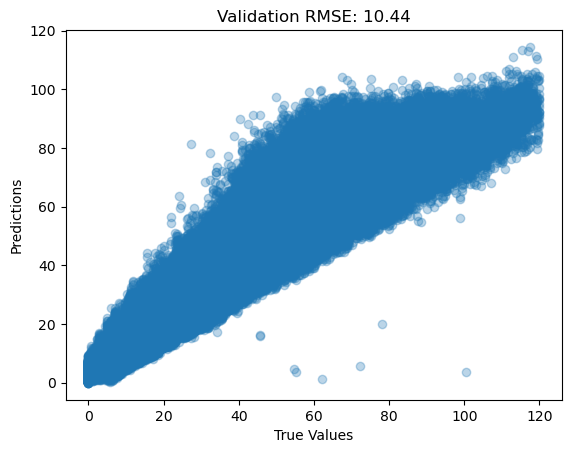

In [19]:
plt.scatter(y_val, y_pred, alpha=0.3)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title(f"Validation RMSE: {rmse:.2f}")
plt.show()